In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class FHNDataLoader(Dataset):
    def __init__(self, num_samples, t_max=100, dt=0.01):
        """
        Initialize the dataset by generating data based on the FHN model.

        Args:
            num_samples (int): Number of samples to generate.
            t_max (float): Maximum time for the simulation.
            dt (float): Time step for the Euler solver.
        """
        self.num_samples = num_samples
        self.t_max = t_max
        self.dt = dt

        # Generate the training data during initialization
        training_data = self.generate_fhn_data(num_samples)
        self.inputs, self.outputs = self.prepare_data_for_loader(training_data)

    def fhn_equations(self, U, W, K):
        """FitzHugh-Nagumo equations."""
        dU_dt = K * U * (U - 0.4) * (1 - U) - W
        dW_dt = 0.5 * (0.2 * U - 0.8 * W)
        return dU_dt, dW_dt

    def euler_solver(self, u0, w0, K, t_max, dt):
        """Solve FHN model using Euler's method."""
        t = np.arange(0, t_max, dt)
        u = np.zeros_like(t)
        w = np.zeros_like(t)
        u[0], w[0] = u0, w0
        for i in range(1, len(t)):
            du_dt, dw_dt = self.fhn_equations(u[i - 1], w[i - 1], K)
            u[i] = u[i - 1] + du_dt * dt
            w[i] = w[i - 1] + dw_dt * dt
        return t, u, w

    def generate_fhn_data(self, num_samples):
        """Generate data for different initial conditions and K values."""
        data = []
        for i in range(num_samples):
            u0 = np.random.uniform(0.5, 0.6)  # Vary U0
            w0 = np.random.uniform(0, 0.1)    # Vary W0
            K = np.random.uniform(2, 2.5)     # Vary K
            t, u, w = self.euler_solver(u0, w0, K, self.t_max, self.dt)
            data.append({'t': t, 'u0': u0, 'w0': w0, 'K': K, 'u': u, 'w': w})
        return data

    def prepare_data_for_loader(self, training_data):
        """Prepare the dataset for the DataLoader for the MLP model."""
        inputs = []
        outputs = []

        for sample in training_data:
            u0 = sample['u0']
            w0 = sample['w0']
            K = sample['K']
            t_values = sample['t']
            u_values = sample['u']
            w_values = sample['w']

            # For each time point in the time series
            for i in range(len(t_values)):
                t = t_values[i]
                u = u_values[i]
                w = w_values[i]

                # Input: [U0, W0, K, t]
                inputs.append([u0, w0, K, t])

                # Output: [U, W]
                outputs.append([u, w])

        # Convert lists to tensors
        inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
        outputs_tensor = torch.tensor(outputs, dtype=torch.float32)

        return inputs_tensor, outputs_tensor

    def __len__(self):
        """Return the total number of samples in the dataset."""
        return len(self.inputs)

    def __getitem__(self, idx):
        """
        Retrieve the input-output pair at the specified index.

        Args:
            idx (int): Index of the data point.

        Returns:
            tuple: (input, output) where input is [U0, W0, K, t] and output is [U, W].
        """
        return self.inputs[idx], self.outputs[idx]

# Example usage:
num_samples = 1000  # Number of FHN samples to generate
batch_size = 32     # Batch size for DataLoader

# Instantiate the dataset
fhn_dataset = FHNDataLoader(num_samples=num_samples, t_max = 10)

# Calculate the sizes for the train and validation sets
train_size = int(0.8 * len(fhn_dataset))
val_size = len(fhn_dataset) - train_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = random_split(fhn_dataset, [train_size, val_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Example: Iterating over the DataLoader
for batch_idx, (input_batch, output_batch) in enumerate(train_loader):
    print(f"Training Batch {batch_idx + 1}:")
    print(f"Input: {input_batch.shape}")
    print(f"Output: {output_batch.shape}")
    # break  # To only show the first batch

for batch_idx, (input_batch, output_batch) in enumerate(val_loader):
    print(f"Validation Batch {batch_idx + 1}:")
    print(f"Input: {input_batch.shape}")
    print(f"Output: {output_batch.shape}")
    # break  # To only show the first batch


In [ ]:
# import torch
# import torch.nn as nn

# # Check if GPU is available, else use CPU
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(f"Using device: {device}")

# class FHNMLPModel(nn.Module):
#     def __init__(self, input_size=4, hidden_size=10, output_size=2, num_hidden_layers=2):
#         super(FHNMLPModel, self).__init__()

#         # Define the input layer
#         self.input_layer = nn.Linear(input_size, hidden_size)

#         # Define hidden layers
#         self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])

#         # Define the output layer
#         self.output_layer = nn.Linear(hidden_size, output_size)

#         # Activation function
#         self.activation = nn.Tanh()

#     def forward(self, x):
#         # Pass input through the input layer
#         x = self.activation(self.input_layer(x))

#         # Pass through all hidden layers
#         for hidden_layer in self.hidden_layers:
#             x = self.activation(hidden_layer(x))

#         # Pass through the output layer
#         output = self.output_layer(x)

#         return output




In [ ]:
# class FHN_Network(nn.Module):
#     def __init__(self, hidden_layers=10, hidden_units=300):
#         super(FHN_Network, self).__init__()
#         layers = []
#         input_dim = 4  # [U0, W0, K, t]
#         output_dim = 2  # [U, W]

#         # Define the network layers
#         for _ in range(hidden_layers):
#             layers.append(nn.Linear(input_dim, hidden_units))
#             layers.append(nn.ReLU())  # Adding ReLU activation after each hidden layer
#             input_dim = hidden_units

#         # Output layer for U and W
#         layers.append(nn.Linear(hidden_units, output_dim))  # This should output 2 values (U, W)

#         # Combine layers into a sequential model
#         self.model = nn.Sequential(*layers)

#     def forward(self, x):
#         return self.model(x)  # This should return a tensor with 2 values (U, W)


In [ ]:
import torch
import torch.nn as nn

# Check if GPU is available, else use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class FHNMLPModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=300, output_size=2, num_hidden_layers=10):
        super(FHNMLPModel, self).__init__()

        # Define the input layer
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Define hidden layers
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers)])

        # Define the output layer (2 outputs: u_pred, w_pred)
        self.output_layer = nn.Linear(hidden_size, output_size)  # Output layer with 2 neurons

        # Activation function (Tanh is often used for such tasks)
        self.activation = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the network.

        x: Input tensor containing the parameters [U0, W0, K, t]
        Returns the network predictions for U and W (u_pred, w_pred)
        """
        # Pass input through the input layer with activation
        x = self.activation(self.input_layer(x))

        # Pass through all hidden layers with activation
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))

        # Output layer produces two values: u_pred and w_pred
        output = self.output_layer(x)

        # Unpack the output into u_pred and w_pred
        u_pred, w_pred = output[:, 0], output[:, 1]

        return u_pred, w_pred  # Return the two values separately


Using device: cuda


In [ ]:
import torch
import torch.nn as nn

def physics_informed_loss(model, inputs, K, t, criterion):
    """
    Physics-informed loss that enforces the FHN model constraints on the predictions.

    Args:
        model: The neural network model.
        inputs: Input tensor of shape (batch_size, 4) with [u0, w0, K, t].
        K: A constant or input tensor related to the model's K parameter.
        t: Time tensor.
        criterion: Loss function to use (typically MSE).

    Returns:
        loss: The total physics-informed loss.
    """
    # Unpack inputs
    u0, w0, K, t = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]

    # Perform the forward pass through the network
    u_pred, w_pred = model(inputs)

    # Compute the residuals of the FHN equations
    du_dt_pred = K * u_pred * (u_pred - 0.4) * (1 - u_pred) - w_pred
    dw_dt_pred = 0.5 * (0.2 * u_pred - 0.8 * w_pred)

    # Compute the time derivative using numerical differentiation
    dt = t[1] - t[0]  # Assuming equal time steps

    # Adjusted gradient calculation
    du_dt_true = torch.gradient(u_pred, spacing=dt, dim=0)[0]  # Getting the first gradient component
    dw_dt_true = torch.gradient(w_pred, spacing=dt, dim=0)[0]  # Getting the first gradient component

    # Compute the loss terms for the physics-informed loss
    loss_u = torch.mean((du_dt_pred - du_dt_true) ** 2)
    loss_w = torch.mean((dw_dt_pred - dw_dt_true) ** 2)

    # Aggregate the total loss
    loss = loss_u + loss_w
    return loss


In [ ]:
def initial_condition_loss(model, inputs, u0, w0):
    """
    Loss that enforces the initial condition constraint.
    """
    # Perform the forward pass through the network
    u_pred, w_pred = model(inputs)

    # Get the initial conditions (t=0)
    u_at_t0 = u_pred[0]  # Assuming the first time point corresponds to t=0
    w_at_t0 = w_pred[0]

    # Compute the loss
    loss_u0 = torch.mean((u_at_t0 - u0) ** 2)
    loss_w0 = torch.mean((w_at_t0 - w0) ** 2)

    # Aggregate the total initial condition loss
    loss = loss_u0 + loss_w0
    return loss


In [ ]:
def data_driven_loss(model, inputs, u_solver, w_solver):
    """
    Loss that enforces the data-driven constraint, comparing network predictions with the solver results.
    """
    # Perform the forward pass through the network
    u_pred, w_pred = model(inputs)

    # Compute the L2 loss between the network prediction and the solver results
    loss_u = torch.mean((u_pred - u_solver) ** 2)
    loss_w = torch.mean((w_pred - w_solver) ** 2)

    # Aggregate the total data-driven loss
    loss = loss_u + loss_w
    return loss


In [ ]:
def total_loss(model, inputs, u_solver, w_solver, u0, w0, K, t, lambda_LD, lambda_LI, lambda_LB):
    """
    Total loss function that combines the data-driven, physics-informed, and initial condition losses.
    """
    # Compute individual losses
    loss_LD =0
    loss_LI =0
    loss_LB =0

    loss_LD = data_driven_loss(model, inputs, u_solver, w_solver)
    # loss_LI = physics_informed_loss(model, inputs, K, t, None)  # Assuming 'None' for the criterion
    loss_LB = initial_condition_loss(model, inputs, u0, w0)

    # Combine the losses with the respective lambda coefficients
    loss = lambda_LD * loss_LD + lambda_LI * loss_LI + lambda_LB * loss_LB
    return loss


In [ ]:
# Instantiate the model and move it to the selected device (GPU or CPU)
model = FHNMLPModel().to(device)

# Check the model architecture
print(model)

FHNMLPModel(
  (input_layer): Linear(in_features=4, out_features=300, bias=True)
  (hidden_layers): ModuleList(
    (0-9): 10 x Linear(in_features=300, out_features=300, bias=True)
  )
  (output_layer): Linear(in_features=300, out_features=2, bias=True)
  (activation): Tanh()
)


In [ ]:
# Example of setting up loss function and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
lambda_LD = 0.1  # Adjust the weight for the data-driven loss
lambda_LI = 0.1  # Adjust the weight for the physics-informed loss
lambda_LB = 0.1 # Adjust the weight for the initial condition loss

for epoch in range(num_epochs):
    model.train()  # Ensure the model is in training mode
    for batch_idx, (inputs, targets) in enumerate(data_loader):
        # Move inputs and targets to the GPU
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Extract necessary values
        u_solver, w_solver = targets[:, 0], targets[:, 1]  # Assuming solver data is in targets
        u0, w0, K, t = inputs[:, 0], inputs[:, 1], inputs[:, 2], inputs[:, 3]

        # Compute the total loss (LT)
        loss = total_loss(model, inputs, u_solver, w_solver, u0, w0, K, t, lambda_LD, lambda_LI, lambda_LB)

        # Backward pass: Compute gradients and update weights
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")


Epoch [1/10], Loss: 0.0124
Epoch [2/10], Loss: 0.0076
Epoch [3/10], Loss: 0.0123
Epoch [4/10], Loss: 0.0090
Epoch [5/10], Loss: 0.0083
Epoch [6/10], Loss: 0.0135
Epoch [7/10], Loss: 0.0101
Epoch [8/10], Loss: 0.0092
Epoch [9/10], Loss: 0.0091
Epoch [10/10], Loss: 0.0102


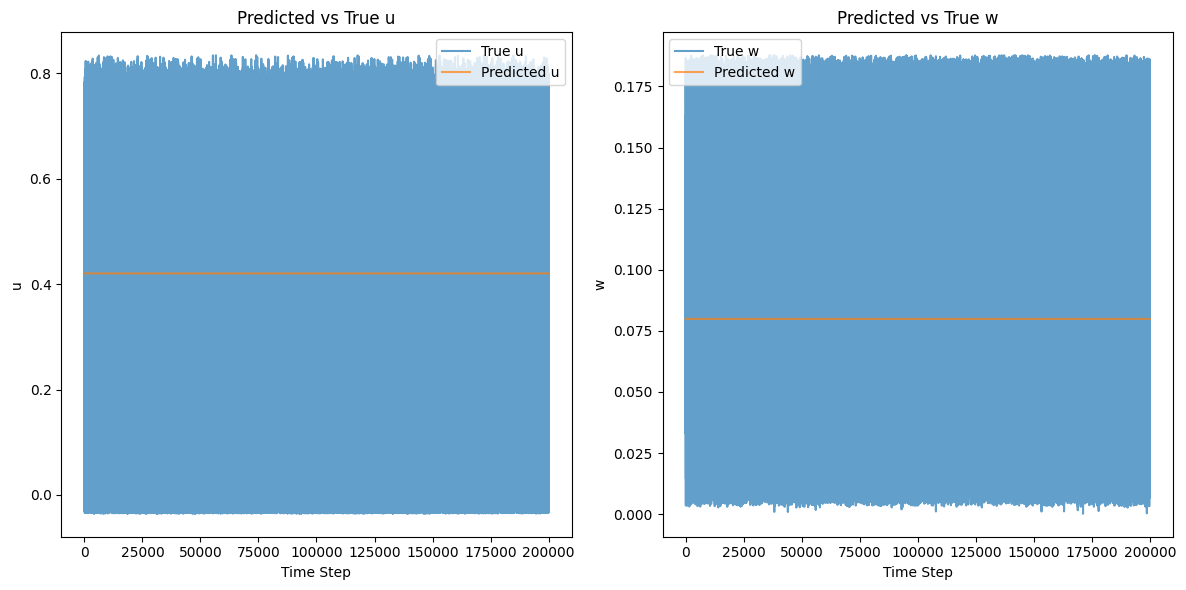

Average Validation Loss: 0.0753


In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Test model on validation set and compute the loss
def test_model_on_val(model, val_loader, criterion):
    """
    Test the model on the validation set and compute the loss.

    Args:
        model: The trained neural network model.
        val_loader: DataLoader for the validation dataset.
        criterion: Loss function to compute the error.

    Returns:
        avg_loss: The average loss for the validation set.
        predictions: List of predicted outputs from the model.
        true_values: List of true values from the validation set.
    """
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    predictions_u = []  # Separate lists for u and w predictions
    predictions_w = []
    true_values_u = []  # Separate lists for u and w true values
    true_values_w = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for inputs, targets in val_loader:
            # Move inputs and targets to the GPU
            inputs = inputs.to(model.input_layer.weight.device)
            targets = targets.to(model.input_layer.weight.device)

            # Forward pass
            u_pred, w_pred = model(inputs)

            # Compute the loss
            loss_u = criterion(u_pred, targets[:, 0])
            loss_w = criterion(w_pred, targets[:, 1])
            loss = loss_u + loss_w
            total_loss += loss.item()

            # Store predictions and true values for plotting
            predictions_u.append(u_pred.cpu().numpy())
            true_values_u.append(targets[:, 0].cpu().numpy())
            predictions_w.append(w_pred.cpu().numpy())
            true_values_w.append(targets[:, 1].cpu().numpy())

    avg_loss = total_loss / len(val_loader)

    # Concatenate separately for u and w
    predictions_u = np.concatenate(predictions_u, axis=0)
    predictions_w = np.concatenate(predictions_w, axis=0)
    true_values_u = np.concatenate(true_values_u, axis=0)
    true_values_w = np.concatenate(true_values_w, axis=0)

    return avg_loss, [predictions_u, predictions_w], [true_values_u, true_values_w]


def plot_predictions(predictions, true_values):
    """
    Plot the predictions and true values for u and w.

    Args:
        predictions: List of predicted outputs from the model.
        true_values: List of true values from the validation set.
    """
    predictions_u, predictions_w = predictions  # Unpack predictions
    true_values_u, true_values_w = true_values  # Unpack true values

    # Plot for u
    plt.figure(figsize=(12, 6))

    # Plot u
    plt.subplot(1, 2, 1)
    plt.plot(true_values_u, label='True u', alpha=0.7)
    plt.plot(predictions_u, label='Predicted u', alpha=0.7)
    plt.title("Predicted vs True u")
    plt.xlabel("Time Step")
    plt.ylabel("u")
    plt.legend()

    # Plot w
    plt.subplot(1, 2, 2)
    plt.plot(true_values_w, label='True w', alpha=0.7)
    plt.plot(predictions_w, label='Predicted w', alpha=0.7)
    plt.title("Predicted vs True w")
    plt.xlabel("Time Step")
    plt.ylabel("w")
    plt.legend()

    plt.tight_layout()
    plt.show()


# Example usage (assuming the model and validation data loader are already defined)
# Define the loss function (e.g., Mean Squared Error)
criterion = torch.nn.MSELoss()

# Assuming `model` is the trained model and `val_loader` is the DataLoader for the validation set
avg_loss, predictions, true_values = test_model_on_val(model, val_loader, criterion)

# Plot the predictions vs true values for u and w
plot_predictions(predictions, true_values)

print(f"Average Validation Loss: {avg_loss:.4f}")


In [ ]:
torch.save(model.state_dict(), 'fhn_model.pth')